# Organize the raw response file into a relational database or an in-memory data structure

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine

# Part 1: import and organize the raw file using pandas

Here I explore the raw dataset and break it down to small dataframes that would represent separate tables in the database.

In [178]:
edu_chile_data = pd.read_csv('edu_chile_survey_output.csv') 

In [179]:
edu_chile_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38004 entries, 0 to 38003
Columns: 108 entries, rut_orig to rbdRating
dtypes: float64(27), int64(1), object(80)
memory usage: 31.3+ MB


In [180]:
#define function that shows the shape and duplicates in subsets:
def summary(data, idvar):
    print('Dups id: ',data[idvar].duplicated().sum())
    print('Dups all vars: ',data.duplicated().sum())
    print('Shape of subset:', data.shape)

Create table 1: student table

In [181]:
student = edu_chile_data[['rut_orig', 'female', 'mom_educ_simce', 
                         'dad_educ_simce', 'rbd', 'q1', 'q3', 
                         'q6_math_orig', 'q6_lang_orig']]

In [182]:
summary(student,'rut_orig')
#student ID - rut_orig, primary key, unique identifier
#as expected - 9 variables

Dups id:  0
Dups all vars:  0
Shape of subset: (38004, 9)


In [183]:
student.head()

,rut_orig,female,mom_educ_simce,dad_educ_simce,rbd,q1,q3,q6_math_orig,q6_lang_orig
0,10000460631,0.0,technical school or some college,technical school or some college,8485.0,NaN,NaN,NaN,NaN
1,10000421312,1.0,8th grade or more,high school,18049.0,Postulare a una institucion de educacion super...,Estoy bastante seguro(a).,580.0,600.0
2,10000274613,1.0,8th grade or more,8th grade or more,1482.0,Postulare a una institucion de educacion super...,Estoy absolutamente seguro(a).,400.0,450.0
3,10000276454,1.0,high school,high school,4553.0,NaN,NaN,NaN,NaN
4,10000439785,1.0,technical school or some college,high school,9767.0,NaN,NaN,NaN,NaN


In [184]:
#remove duplicates
student = student.drop_duplicates()
student = student.dropna(how='all')

summary(student,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (38004, 9)


Create table 2: school table

In [185]:
school = edu_chile_data[['rbd', 'schl_type', 'rbdRating']]

In [186]:
school['rbdRating'].unique()

array(['D', 'C', nan, 'A', 'B', 'E'], dtype=object)

In [187]:
#expect duplicates - the raw dataset had multiple students from one school.
summary(school,'rbd')

Dups id:  35332
Dups all vars:  35332
Shape of subset: (38004, 3)


In [188]:
#remove duplicates
school = school.drop_duplicates()
school = school.dropna(how='all')

summary(school,'rbd')

#2,672 unique schools in the table

Dups id:  0
Dups all vars:  0
Shape of subset: (2671, 3)


In [189]:
school['rbd'].isnull().sum()

0

Create tables 3,4,5 - students' first, second and third choice institutions and perceptions about them (questions 2,4,5).

In [190]:
#table 3
instit_ch1 = edu_chile_data[['rut_orig', 'q2_tipo_1_orig', 'q2_nivel_1', 'q2_inst_1', 
                             'q2_carerra_1', 'q4_cost_1_orig', 'q4_nose_1_orig', 
                             'q5_mi_ing_1_orig', 'q5_mi_nose_1_orig', 
                             'q5_tip_ing_1_orig', 'q5_tip_nose_1_orig']]

In [191]:
summary(instit_ch1,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (38004, 11)


In [192]:
instit_ch1.isnull().sum()
#there are quite a few students who have not selected their first choice institutions, 
#and this did not answer any 1st choice institution related questions. Remove them

rut_orig                  0
q2_tipo_1_orig         9097
q2_nivel_1             9106
q2_inst_1              9108
q2_carerra_1           9112
q4_cost_1_orig        10765
q4_nose_1_orig            0
q5_mi_ing_1_orig      10848
q5_mi_nose_1_orig         0
q5_tip_ing_1_orig     10753
q5_tip_nose_1_orig        0
dtype: int64

In [193]:
the_indices = [0,1,2,3,4,5,6,7,9]
the_subset = instit_ch1.columns[the_indices]
the_subset

Index(['rut_orig', 'q2_tipo_1_orig', 'q2_nivel_1', 'q2_inst_1', 'q2_carerra_1',
       'q4_cost_1_orig', 'q4_nose_1_orig', 'q5_mi_ing_1_orig',
       'q5_tip_ing_1_orig'],
      dtype='object')

In [194]:
instit_ch1 = instit_ch1.dropna(axis=0, how='all', subset=the_subset)

summary(instit_ch1,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (38004, 11)


In [195]:
#table 4
instit_ch2 = edu_chile_data[['rut_orig', 'q2_tipo_2_orig', 'q2_nivel_2', 'q2_inst_2', 
                             'q2_carerra_2', 'q4_cost_2_orig', 'q4_nose_2_orig', 
                             'q5_mi_ing_2_orig', 'q5_mi_nose_2_orig', 
                             'q5_tip_ing_2_orig', 'q5_tip_nose_2_orig']]

summary(instit_ch2,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (38004, 11)


In [196]:
the_indices = [0,1,2,3,4,5,6,7,9]
the_subset = instit_ch2.columns[the_indices]

In [197]:
instit_ch2 = instit_ch2.dropna(axis=0, how='all', subset=the_subset)

summary(instit_ch2,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (38004, 11)


In [198]:
#table 5
instit_ch3 = edu_chile_data[['rut_orig', 'q2_tipo_3_orig', 'q2_nivel_3', 'q2_inst_3', 
                             'q2_carerra_3', 'q4_cost_3_orig', 'q4_nose_3_orig', 
                             'q5_mi_ing_3_orig', 'q5_mi_nose_3_orig', 
                             'q5_tip_ing_3_orig', 'q5_tip_nose_3_orig']]

summary(instit_ch3,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (38004, 11)


In [199]:
the_indices = [0,1,2,3,4,5,6,7,9]
the_subset = instit_ch3.columns[the_indices]

In [200]:
instit_ch3 = instit_ch3.dropna(axis=0, how='all', subset=instit_ch3.columns[1:6])

summary(instit_ch3,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (24788, 11)


change all columns

In [201]:
new_cols = ['rut_orig', 'q2_tipo_orig', 'q2_nivel', 'q2_inst', 'q2_carerra',
       'q4_cost_orig', 'q4_nose_orig', 'q5_mi_ing_orig',
       'q5_mi_nose_orig', 'q5_tip_ing_orig', 'q5_tip_nose_orig']

instit_list = [instit_ch1, instit_ch2, instit_ch3]

for x in instit_list:
    x.columns = new_cols

Create tables 6-15: students' searches 1-10.

In [202]:
search_1 = edu_chile_data.iloc[:, list(range(1)) + list(range(37,43))]
search_2 = edu_chile_data.iloc[:, list(range(1)) + list(range(43,49))]
search_3 = edu_chile_data.iloc[:, list(range(1)) + list(range(49,55))]
search_4 = edu_chile_data.iloc[:, list(range(1)) + list(range(55,61))]
search_5 = edu_chile_data.iloc[:, list(range(1)) + list(range(61,67))]
search_6 = edu_chile_data.iloc[:, list(range(1)) + list(range(67,73))]
search_7 = edu_chile_data.iloc[:, list(range(1)) + list(range(73,79))]
search_8 = edu_chile_data.iloc[:, list(range(1)) + list(range(79,85))]
search_9 = edu_chile_data.iloc[:, list(range(1)) + list(range(85,91))]
search_10 = edu_chile_data.iloc[:, list(range(1)) + list(range(91,97))]

In [203]:
summary(search_9,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (38004, 7)


In [204]:
search_1 = search_1.dropna(axis=0, how='all', subset=search_1.columns[1:])
search_2 = search_2.dropna(axis=0, how='all', subset=search_2.columns[1:])
search_3 = search_3.dropna(axis=0, how='all', subset=search_3.columns[1:])
search_4 = search_4.dropna(axis=0, how='all', subset=search_4.columns[1:])
search_5 = search_5.dropna(axis=0, how='all', subset=search_5.columns[1:])
search_6 = search_6.dropna(axis=0, how='all', subset=search_6.columns[1:])
search_7 = search_7.dropna(axis=0, how='all', subset=search_7.columns[1:])
search_8 = search_8.dropna(axis=0, how='all', subset=search_8.columns[1:])
search_9 = search_9.dropna(axis=0, how='all', subset=search_9.columns[1:])
search_10 = search_10.dropna(axis=0, how='all', subset=search_10.columns[1:])

In [205]:
summary(search_9,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (99, 7)


In [206]:
new_cols = ['rut_orig', 'search_psu_math', 'search_psu_lang', 'search_area',
       'search_nivel', 'search_carrer', 'search_clicked_button']

search_list = [search_1, search_2, search_3, search_4, search_5, search_6, search_7, search_8, search_9, search_10]

for x in search_list:
    x.columns = new_cols

Create table 16: other values in the raw data that are not explained byt he dictionary

In [207]:
other = edu_chile_data[['rut_orig', 'PSU_leng_2013',
                        'PSU_mate_2013', 'PSU_2013',
                        'SIMCEMath10', 'SIMCELang10']]

summary(other,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (38004, 6)


In [208]:
other = other.dropna(axis=0, how='all', subset=other.columns[1:])

summary(other,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (37282, 6)


Create table 17: survey start and complete times

In [209]:
times = edu_chile_data[edu_chile_data.columns[:3]]

In [210]:
summary(times,'rut_orig')

Dups id:  0
Dups all vars:  0
Shape of subset: (38004, 3)


# Part 2: write raw tables to an in-memory database

Write tables student, school, instit_ch1-3, search_1-10, other and times tables into a edu_chile_data database.

In [211]:
connection = sqlite3.connect("edu_chile_data.db")

cursor = connection.cursor()

In [212]:
# Drop a table name Crypto if it exists already
try:
    connection.execute('DROP TABLE IF EXISTS `Student` ')
    connection.execute('DROP TABLE IF EXISTS `School` ')
    connection.execute('DROP TABLE IF EXISTS `instit_ch1` ')
    connection.execute('DROP TABLE IF EXISTS `instit_ch2` ')
    connection.execute('DROP TABLE IF EXISTS `instit_ch3` ')
    connection.execute('DROP TABLE IF EXISTS `search_1` ')
    connection.execute('DROP TABLE IF EXISTS `search_2` ')
    connection.execute('DROP TABLE IF EXISTS `search_3` ')
    connection.execute('DROP TABLE IF EXISTS `search_4` ')
    connection.execute('DROP TABLE IF EXISTS `search_5` ')
    connection.execute('DROP TABLE IF EXISTS `search_6` ')
    connection.execute('DROP TABLE IF EXISTS `search_7` ')
    connection.execute('DROP TABLE IF EXISTS `search_8` ')
    connection.execute('DROP TABLE IF EXISTS `search_9` ')
    connection.execute('DROP TABLE IF EXISTS `search_10` ')
    connection.execute('DROP TABLE IF EXISTS `other` ')
    connection.execute('DROP TABLE IF EXISTS `times` ')
    
except Exception as e:
    raise(e)
finally:
    print('Tables dropped')

Tables dropped


In [213]:
# Create a new Table named student
try:
    connection.execute('''
         CREATE TABLE Student
         (rut_orig      INTEGER NOT NULL PRIMARY KEY,
         female         Float,
         mom_educ_simce VARCHAR,
         dad_educ_simce VARCHAR,
         rbd            Float,
         q1             VARCHAR,
         q3             VARCHAR,
         q6_math_orig   Float,
         q6_lang_orig   Float
         REFERENCES School (rbd)
         REFERENCES Other (rut_orig)
         REFERENCES Times (rut_orig)         
         REFERENCES instit_ch1 (rut_orig)
         REFERENCES instit_ch2 (rut_orig)
         REFERENCES instit_ch3 (rut_orig)
         REFERENCES search_1 (rut_orig)
         REFERENCES search_2 (rut_orig)
         REFERENCES search_3 (rut_orig)
         REFERENCES search_4 (rut_orig)
         REFERENCES search_5 (rut_orig)
         REFERENCES search_6 (rut_orig)
         REFERENCES search_7 (rut_orig)
         REFERENCES search_8 (rut_orig)
         REFERENCES search_9 (rut_orig)
         REFERENCES search_10 (rut_orig));''')
    print ("Table Student created successfully");
    
    connection.execute('''
         CREATE TABLE School
         (rbd           Float NOT NULL PRIMARY KEY,
         schl_type      VARCHAR,
         rbdRating      CHAR(1));''')
    print ("Table School created successfully");  
   
    connection.execute('''
        CREATE TABLE Other
        (rut_orig       INTEGER NOT NULL PRIMARY KEY,
         PSU_leng_2013  Float,
         PSU_mate_2013  Float,
         PSU_2013       Float,
         SIMCEMath10    Float,
         SIMCELang10    Float);''')
    print("Table Other created successfully");
  
    connection. execute('''
        CREATE TABLE Times
        (rut_orig      INTEGER NOT NULL PRIMARY KEY,
         start_date    Datetime,
         completed_date Datetime);''')
    print("Table Times created successfully");
    
except Exception as e:
    print(str(e))
    print("Table Creation Failed!!!!!")
finally:
    print("All tables created") 

Table Student created successfully
Table School created successfully
Table Other created successfully
Table Times created successfully
All tables created


In [214]:
for x in range(1,4):
    try:
        connection.execute('''
         CREATE TABLE instit_ch%s
         (rut_orig     INTEGER NOT NULL PRIMARY KEY,
          q2_tipo_orig VARCHAR,
          q2_nivel     VARCHAR,
          q2_inst      VARCHAR,
          q2_carerra   VARCHAR,
          q4_cost_orig VARCHAR,
          q4_nose_orig VARCHAR,
          q5_mi_ing_orig VARCHAR,
          q5_mi_nose_orig VARCHAR,
          q5_tip_ing_orig VARCHAR,
          q5_tip_nose_orig VARCHAR)'''%x)
        print ("Table instit_ch%s created successfully"%x);
    except Exception as e:
        print(str(e))
        print('Table Creation Failed!!!!!')
    finally:
        print("All tables created")

Table instit_ch1 created successfully
All tables created
Table instit_ch2 created successfully
All tables created
Table instit_ch3 created successfully
All tables created


In [215]:
for x in range(1,11):
    try:
        connection.execute('''
         CREATE TABLE search_%s
         (rut_orig      INTEGER NOT NULL PRIMARY KEY,
          search_psu_math Float,
          search_psu_lang INTEGER,
          search_area     VARCHAR,
          search_nivel    VARCHAR,
          search_carrer   VARCHAR,
          search_clicked_button VARCHAR)'''%x)
        print ("Table search_%s created successfully"%x);
    except Exception as e:
        print(str(e))
        print('Table Creation Failed!!!!!')
    finally:
        print("All tables created")
        
connection.close() 

Table search_1 created successfully
All tables created
Table search_2 created successfully
All tables created
Table search_3 created successfully
All tables created
Table search_4 created successfully
All tables created
Table search_5 created successfully
All tables created
Table search_6 created successfully
All tables created
Table search_7 created successfully
All tables created
Table search_8 created successfully
All tables created
Table search_9 created successfully
All tables created
Table search_10 created successfully
All tables created


In [216]:
student_list = student.values.tolist()

# lets make new connection to Insert crypto data in SQL DB
connection = sqlite3.connect('edu_chile_data.db')

# make a cursor - it will help with querying SQL DB
cur = connection.cursor()

try:
    cur.executemany("INSERT INTO Student(rut_orig, female, mom_educ_simce, dad_educ_simce, rbd, q1, q3, q6_math_orig, q6_lang_orig) VALUES (?,?,?,?,?,?,?,?,?)", student_list)
    connection.commit()
    print('Data Inserted Successfully')
except Exception as e:
    print(str(e))
    print('Data Insertion Failed')
finally:
    # finally block will help with always closing the connection to DB even in case of error.
    connection.close()

Data Inserted Successfully


In [217]:
school_list = school.values.tolist()

# lets make new connection to Insert crypto data in SQL DB
connection = sqlite3.connect('edu_chile_data.db')

# make a cursor - it will help with querying SQL DB
cur = connection.cursor()

try:
    cur.executemany("INSERT INTO School(rbd, schl_type, rbdRating) VALUES (?,?,?)", school_list)
    connection.commit()
    print('Data Inserted Successfully')
except Exception as e:
    print(str(e))
    print('Data Insertion Failed')
finally:
    # finally block will help with always closing the connection to DB even in case of error.
    connection.close()

Data Inserted Successfully


In [218]:
other_list = other.values.tolist()

# lets make new connection to Insert crypto data in SQL DB
connection = sqlite3.connect('edu_chile_data.db')

# make a cursor - it will help with querying SQL DB
cur = connection.cursor()
           
try:
    cur.executemany("INSERT INTO Other(rut_orig, PSU_leng_2013, PSU_mate_2013, PSU_2013, SIMCEMath10, SIMCELang10) VALUES (?,?,?,?,?,?)", other_list)
    connection.commit()
    print('Data Inserted Successfully')
except Exception as e:
    print(str(e))
    print('Data Insertion Failed')
finally:
    # finally block will help with always closing the connection to DB even in case of error.
    connection.close()

Data Inserted Successfully


In [219]:
times_list = times.values.tolist()

# lets make new connection to Insert crypto data in SQL DB
connection = sqlite3.connect('edu_chile_data.db')

# make a cursor - it will help with querying SQL DB
cur = connection.cursor()
           
try:
    cur.executemany("INSERT INTO Times(rut_orig, start_date, completed_date) VALUES (?,?,?)", times_list)
    connection.commit()
    print('Data Inserted Successfully')
except Exception as e:
    print(str(e))
    print('Data Insertion Failed')
finally:
    # finally block will help with always closing the connection to DB even in case of error.
    connection.close()

Data Inserted Successfully


In [220]:
instit_ch1_list, instit_ch2_list, instit_ch3_list = [i.values.tolist() for i in [instit_ch1, instit_ch2, instit_ch3]]

# lets make new connection to Insert crypto data in SQL DB
connection = sqlite3.connect('edu_chile_data.db')

# make a cursor - it will help with querying SQL DB
cur = connection.cursor()
try:
    cur.executemany("INSERT INTO instit_ch1(rut_orig, q2_tipo_orig, q2_nivel, q2_inst, q2_carerra, q4_cost_orig, q4_nose_orig, q5_mi_ing_orig, q5_mi_nose_orig, q5_tip_ing_orig, q5_tip_nose_orig) VALUES (?,?,?,?,?,?,?,?,?,?,?)", instit_ch1_list)
    connection.commit()
    print('Data Inserted Successfully')
    cur.executemany("INSERT INTO instit_ch2(rut_orig, q2_tipo_orig, q2_nivel, q2_inst, q2_carerra, q4_cost_orig, q4_nose_orig, q5_mi_ing_orig, q5_mi_nose_orig, q5_tip_ing_orig, q5_tip_nose_orig) VALUES (?,?,?,?,?,?,?,?,?,?,?)", instit_ch2_list)
    connection.commit()
    print('Data Inserted Successfully')
    cur.executemany("INSERT INTO instit_ch3(rut_orig, q2_tipo_orig, q2_nivel, q2_inst, q2_carerra, q4_cost_orig, q4_nose_orig, q5_mi_ing_orig, q5_mi_nose_orig, q5_tip_ing_orig, q5_tip_nose_orig) VALUES (?,?,?,?,?,?,?,?,?,?,?)", instit_ch3_list)
    connection.commit()
    print('Data Inserted Successfully')    
except Exception as e:
    print(str(e))
    print('Data Insertion Failed')
finally:
    # finally block will help with always closing the connection to DB even in case of error.
    print("done")

Data Inserted Successfully
Data Inserted Successfully
Data Inserted Successfully
done


In [221]:
search_1_list, search_2_list, search_3_list, search_4_list, search_5_list, search_6_list, search_7_list, search_8_list, search_9_list, search_10_list = [i.values.tolist() for i in search_list]

In [222]:
search_list = ['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7', 'search_8', 'search_9', 'search_10']


In [223]:
# lets make new connection to Insert crypto data in SQL DB
connection = sqlite3.connect('edu_chile_data.db')

# make a cursor - it will help with querying SQL DB
cur = connection.cursor()

try:
    cur.executemany("INSERT INTO search_1(rut_orig, search_psu_math, search_psu_lang, search_area, search_nivel, search_carrer, search_clicked_button) VALUES (?,?,?,?,?,?,?)", search_1_list)
    connection.commit()
    print('Data Inserted Successfully')
    cur.executemany("INSERT INTO search_2(rut_orig, search_psu_math, search_psu_lang, search_area, search_nivel, search_carrer, search_clicked_button) VALUES (?,?,?,?,?,?,?)", search_2_list)
    connection.commit()
    print('Data Inserted Successfully')
    cur.executemany("INSERT INTO search_3(rut_orig, search_psu_math, search_psu_lang, search_area, search_nivel, search_carrer, search_clicked_button) VALUES (?,?,?,?,?,?,?)", search_3_list)
    connection.commit()
    print('Data Inserted Successfully')
    cur.executemany("INSERT INTO search_4(rut_orig, search_psu_math, search_psu_lang, search_area, search_nivel, search_carrer, search_clicked_button) VALUES (?,?,?,?,?,?,?)", search_4_list)
    connection.commit()
    print('Data Inserted Successfully')
    cur.executemany("INSERT INTO search_5(rut_orig, search_psu_math, search_psu_lang, search_area, search_nivel, search_carrer, search_clicked_button) VALUES (?,?,?,?,?,?,?)", search_5_list)
    connection.commit()
    print('Data Inserted Successfully')
    cur.executemany("INSERT INTO search_6(rut_orig, search_psu_math, search_psu_lang, search_area, search_nivel, search_carrer, search_clicked_button) VALUES (?,?,?,?,?,?,?)", search_6_list)
    connection.commit()
    print('Data Inserted Successfully')
    cur.executemany("INSERT INTO search_7(rut_orig, search_psu_math, search_psu_lang, search_area, search_nivel, search_carrer, search_clicked_button) VALUES (?,?,?,?,?,?,?)", search_7_list)
    connection.commit()
    print('Data Inserted Successfully')
    cur.executemany("INSERT INTO search_8(rut_orig, search_psu_math, search_psu_lang, search_area, search_nivel, search_carrer, search_clicked_button) VALUES (?,?,?,?,?,?,?)", search_8_list)
    connection.commit()
    print('Data Inserted Successfully')
    cur.executemany("INSERT INTO search_9(rut_orig, search_psu_math, search_psu_lang, search_area, search_nivel, search_carrer, search_clicked_button) VALUES (?,?,?,?,?,?,?)", search_9_list)
    connection.commit()
    print('Data Inserted Successfully')
    cur.executemany("INSERT INTO search_10(rut_orig, search_psu_math, search_psu_lang, search_area, search_nivel, search_carrer, search_clicked_button) VALUES (?,?,?,?,?,?,?)", search_10_list)
    connection.commit()
    print('Data Inserted Successfully')  
except Exception as e:
    print(str(e))
    print('Data Insertion Failed')
finally:
    # finally block will help with always closing the connection to DB even in case of error.
    connection.close()

Data Inserted Successfully
Data Inserted Successfully
Data Inserted Successfully
Data Inserted Successfully
Data Inserted Successfully
Data Inserted Successfully
Data Inserted Successfully
Data Inserted Successfully
Data Inserted Successfully
Data Inserted Successfully


In [224]:
# Let's Read data from DB to verify it

connection = sqlite3.connect('edu_chile_data.db')
rows = connection.cursor().execute('SELECT rut_orig, s.rbd FROM student as s INNER JOIN school as sh ON s.rbd=sh.rbd WHERE sh.schl_type == "Private"')
# print(rows[:2])
for row in rows:
    print(row)
connection.close()

(10001420733, 3204.0)
(10002189373, 24896.0)
(10002263453, 11291.0)
(10002595550, 5810.0)
(10010826567, 11291.0)
(10011732114, 8878.0)
(10012448268, 24840.0)
(10013526993, 1225.0)
(10013746148, 9003.0)
(10014709409, 26030.0)
(10014740997, 3015.0)
(10015411118, 14338.0)
(10015767819, 9054.0)
(10016003977, 26046.0)
(10016562896, 10635.0)
(10017241230, 7700.0)
(10018248842, 2790.0)
(10018647630, 8755.0)
(10019329279, 1638.0)
(10019472372, 8761.0)
(10020122123, 26046.0)
(10020565346, 24671.0)
(10021885771, 8984.0)
(10021961199, 24986.0)
(10023387521, 8996.0)
(10023511555, 4796.0)
(10024001506, 24678.0)
(10025862365, 25366.0)
(10027738962, 5808.0)
(10028492140, 14217.0)
(10028892640, 25190.0)
(10029367404, 1225.0)
(10029989341, 4798.0)
(10030138325, 358.0)
(10030143601, 9135.0)
(10030859559, 17606.0)
(10030897260, 25478.0)
(10031788212, 2789.0)
(10032187299, 13434.0)
(10032434866, 357.0)
(10032786206, 1634.0)
(10033188843, 6844.0)
(10033608117, 24985.0)
(10033772733, 24699.0)
(10034635418, 

(12732615751, 8863.0)
(12732630875, 10834.0)
(12735111313, 24802.0)
(12741428019, 24783.0)
(12747529527, 11291.0)
(12749814707, 12183.0)
(12749824035, 9267.0)
(12751534306, 17697.0)
(12752010842, 7742.0)
(12752314747, 12966.0)
(12753017828, 8956.0)
(12754923535, 8978.0)
(12762523760, 8877.0)
(12764520387, 4689.0)
(12765229487, 24988.0)
(12767310290, 69.0)
(12769512101, 2200.0)
(12769522167, 8978.0)
(12774027113, 8757.0)
(12779036271, 15631.0)
(12780412258, 16458.0)
(12786328092, 2260.0)
(12787114499, 25134.0)
(12789524587, 40278.0)
(12789624435, 14466.0)
(12789916302, 2790.0)
(12793522936, 24933.0)
(12794122682, 9250.0)
(12795518133, 4285.0)
(12795532315, 9246.0)
(12795619479, 24896.0)
(12800521468, 24840.0)
(12801831899, 4689.0)
(12803718382, 4679.0)
(12806930998, 770.0)
(12811136580, 24670.0)
(12811232964, 15510.0)
(12814520109, 13434.0)
(12818711481, 11685.0)
(12820511381, 9221.0)
(12820634817, 24802.0)
(12827633165, 69.0)
(12830234613, 24670.0)
(12834928848, 24830.0)
(12835121775, 

### Visual representation of the table

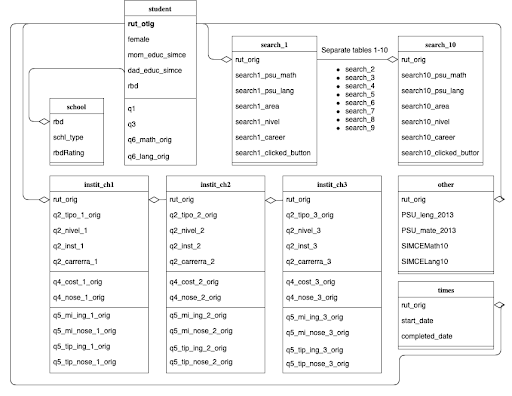

In [227]:
from IPython.display import Image
Image(filename='Schema.png')

### Alternative way of adding tables to database

In [122]:
engine = create_engine('sqlite:///:memory:')

#student table
student.to_sql('student', engine)
#school table
school.to_sql('school', engine)
#instit_ch1-3 tables
instit_ch1.to_sql('instit_ch1', engine)
instit_ch2.to_sql('instit_ch2', engine)
instit_ch3.to_sql('instit_ch3', engine)
#search_1-10 tables
search_1.to_sql('search_1', engine)
search_2.to_sql('search_2', engine)
search_3.to_sql('search_3', engine)
search_4.to_sql('search_4', engine)
search_5.to_sql('search_5', engine)
search_6.to_sql('search_6', engine)
search_7.to_sql('search_7', engine)
search_8.to_sql('search_8', engine)
search_9.to_sql('search_9', engine)
search_10.to_sql('search_10', engine)
#other table
other.to_sql('other', engine)
#times table
times.to_sql('times', engine)

In [139]:
# Query 1 extracting the mean language score for females
pd.read_sql_query('SELECT AVG(q6_lang_orig) as "Mean Lang score" FROM student WHERE female=1', engine)

,Mean Lang score
0,578.574319


In [137]:
#Query 2, joining two relational tables
pd.read_sql_query('SELECT rut_orig, s.rbd FROM student as s INNER JOIN school as sh ON s.rbd=sh.rbd WHERE sh.schl_type == "Private"', engine)

,rut_orig,rbd
0,10001420733,3204.0
1,10112804191,3204.0
2,10176215273,3204.0
3,10267386724,3204.0
4,11213326211,3204.0
...,...,...
2314,12528836790,9228.0
2315,12896835327,9228.0
2316,12732036297,3012.0
2317,14373036310,9004.0


In [ ]:
connection.close()